In [45]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
pd.options.plotting.backend = 'matplotlib' # add small interactivity to the plot
import plotly.express as px
import seaborn as sns
from factor_analyzer import FactorAnalyzer # this will be used for factor analysis later when working with latent variables
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # ignore future version warnings

In [46]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [47]:
#   combine datasets, they are same layout so concat will work
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39030 entries, 0 to 39029
Data columns (total 80 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   UID                          39030 non-null  int64  
 1   BLOCKID                      0 non-null      float64
 2   SUMLEVEL                     39030 non-null  int64  
 3   COUNTYID                     39030 non-null  int64  
 4   STATEID                      39030 non-null  int64  
 5   state                        39030 non-null  object 
 6   state_ab                     39030 non-null  object 
 7   city                         39030 non-null  object 
 8   place                        39030 non-null  object 
 9   type                         39030 non-null  object 
 10  primary                      39030 non-null  object 
 11  zip_code                     39030 non-null  int64  
 12  area_code                    39030 non-null  int64  
 13  lat             

In [48]:
#   checking uniqueness of UID to determine if it is a primary key
is_unique = len(df['UID']) == len(set(df['UID']))
print(f"Is 'UID' unique?: {is_unique}")

#   checking for null values
has_null = df['UID'].isnull().any()
print(f"Does 'UID' have null values?: {has_null}")

#   check how many UID values are not unique
repeat_values = len(df['UID']) - len(set(df['UID']))
print(f"Number of repeat 'UID' values: {repeat_values} ")


Is 'UID' unique?: False
Does 'UID' have null values?: False
Number of repeat 'UID' values: 315 


In [49]:
#   provide a means to look at each duplicated value via Input
rows_with_uid = df.loc[df['UID'] == int(input('Row based on UID to look up'))]
print(rows_with_uid) # This will print an empty dataframe if no duplicate is found matching the input 

Empty DataFrame
Columns: [UID, BLOCKID, SUMLEVEL, COUNTYID, STATEID, state, state_ab, city, place, type, primary, zip_code, area_code, lat, lng, ALand, AWater, pop, male_pop, female_pop, rent_mean, rent_median, rent_stdev, rent_sample_weight, rent_samples, rent_gt_10, rent_gt_15, rent_gt_20, rent_gt_25, rent_gt_30, rent_gt_35, rent_gt_40, rent_gt_50, universe_samples, used_samples, hi_mean, hi_median, hi_stdev, hi_sample_weight, hi_samples, family_mean, family_median, family_stdev, family_sample_weight, family_samples, hc_mortgage_mean, hc_mortgage_median, hc_mortgage_stdev, hc_mortgage_sample_weight, hc_mortgage_samples, hc_mean, hc_median, hc_stdev, hc_samples, hc_sample_weight, home_equity_second_mortgage, second_mortgage, home_equity, debt, second_mortgage_cdf, home_equity_cdf, debt_cdf, hs_degree, hs_degree_male, hs_degree_female, male_age_mean, male_age_median, male_age_stdev, male_age_sample_weight, male_age_samples, female_age_mean, female_age_median, female_age_stdev, female_a

In [50]:
#   drop all duplicated values except for the first occurence
df_no_duplicates = df.drop_duplicates(subset='UID', keep='first', inplace=True)
print(df_no_duplicates)

None


In [51]:
#   Gauge fill rate of variables to determine missing value treatment, with lowest percentage at top
fill_rate = df.count() / len(df) * 100
pd.set_option('display.max_rows', None) # command to show more than just the 5 head and 5 tail results
print(f"Percentage of variable fill rate: \n{fill_rate.sort_values(ascending=True)}")
pd.reset_option('display.max_rows') # reset the display option back to default value

Percentage of variable fill rate: 
BLOCKID                          0.000000
hc_mean                         98.346894
hc_sample_weight                98.346894
hc_samples                      98.346894
hc_stdev                        98.346894
hc_median                       98.346894
hc_mortgage_samples             98.463128
hc_mortgage_median              98.463128
hc_mortgage_stdev               98.463128
hc_mortgage_sample_weight       98.463128
hc_mortgage_mean                98.463128
home_equity_second_mortgage     98.742090
second_mortgage                 98.742090
home_equity                     98.742090
debt                            98.742090
home_equity_cdf                 98.742090
second_mortgage_cdf             98.742090
debt_cdf                        98.742090
rent_gt_15                      99.170864
rent_gt_35                      99.170864
rent_gt_40                      99.170864
rent_gt_50                      99.170864
rent_gt_30                      99.170864

Treatment of missing values

In [52]:
#   ensure every value in Primary is 'tract'
tract_count = df[df['primary'] == 'tract'].shape[0]
print(f"{tract_count} out of {df.shape[0]}")
# No places are of primary type Block, so the column is not needed
df.drop('BLOCKID', axis=1, inplace=True)
print('BLOCKID Dropped')

38715 out of 38715
BLOCKID Dropped


In [53]:
#   fill all null values with the mean of their respective columns. ensure only numeric columns are factored
df.fillna(df.mean(numeric_only=True), inplace=True)
print("Numeric columns mean imputed")

#   check for any non-numeric null values
df.select_dtypes(exclude='number').isna().sum().sum()

Numeric columns mean imputed


0

Debt Analysis: Top 2,500 locations where the percentage of households with a second 
mortgage is the highest and percent ownership is above 10 percent. Visualize using 
geo-map. Keep the upper limit for the percent of households with a second 
mortgage to 50 percent.

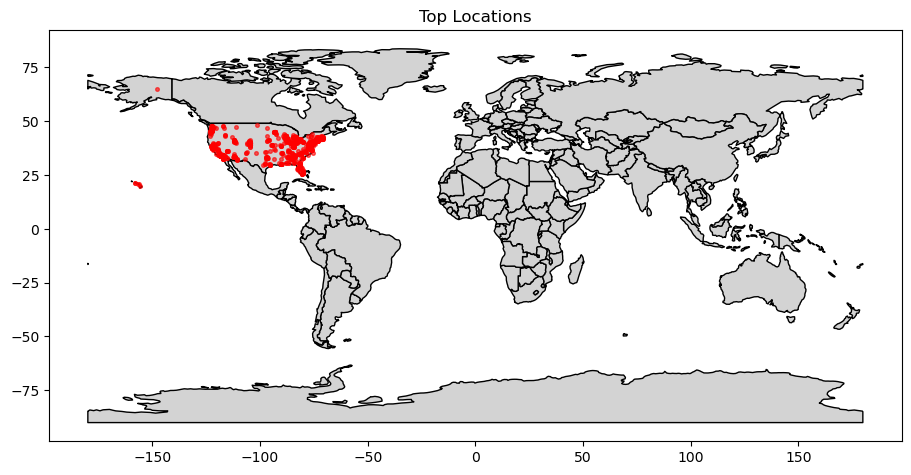

In [54]:
#  find the rows where Second Mortgage is between 10 and 50 percent, and pct_own is greater than 10 percent
filtered_data = df[(df['second_mortgage'].between(.10, .50)) & (df['pct_own'] > .10)]

# sort and select top locations
top_locations = filtered_data.sort_values(by='second_mortgage', ascending=False).head(2500)

# assign geopanda variables
geometry = [Point(xy) for xy in zip(filtered_data['lng'], filtered_data['lat'])]
gdf = gpd.GeoDataFrame(filtered_data, geometry=geometry)

# plot the GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(11, 6), color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', marker='o', markersize=7, alpha=0.6)
plt.title('Top Locations')
plt.show()

In [55]:
# Bad Debt = P (Second Mortgage ∩ Home Equity Loan)
df['bad_debt'] = df['second_mortgage'] + df['home_equity'] - df['home_equity_second_mortgage']
df['overall_debt'] = df['second_mortgage'] + df['home_equity']

In [56]:
#  slightly interactive graph that allows for viewing of value totals
pie_data = pd.DataFrame({
    'Category': ['Overall Debt', 'Bad Debt'],
    'Value': [df['overall_debt'].sum(), df['bad_debt'].sum()]
})
fig = px.pie(pie_data, values='Value', names='Category', title='Overall Debt and Bad Debt Pie Chart', width= 400, height= 300)
fig.show()

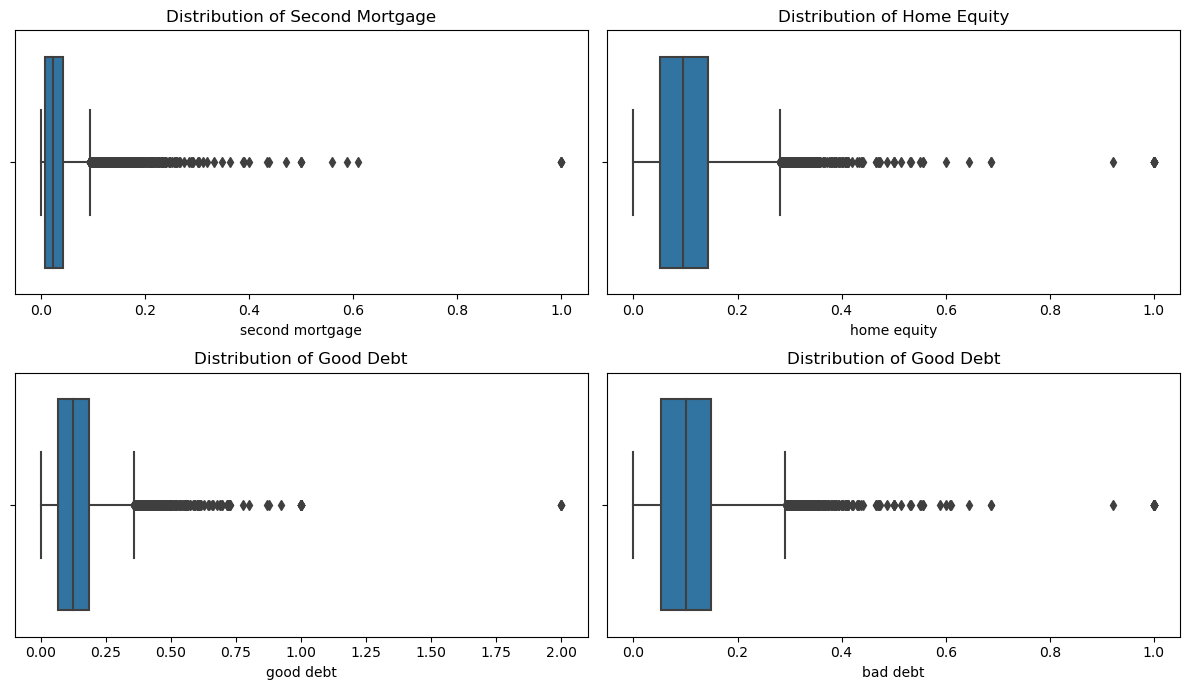

In [57]:
# Set the size of the plot
plt.figure(figsize=(12, 7))

# Boxplot for Second Mortgage
plt.subplot(2, 2, 1)
sns.boxplot(x='second_mortgage', data=df)
plt.xlabel('second mortgage')
plt.title('Distribution of Second Mortgage')

# Boxplot for Home Equity
plt.subplot(2, 2, 2)
sns.boxplot(x='home_equity', data=df)
plt.xlabel('home equity')
plt.title('Distribution of Home Equity')

# Boxplot for Good Debt
plt.subplot(2, 2, 3)
sns.boxplot(x='overall_debt', data=df)
plt.xlabel('good debt')
plt.title('Distribution of Good Debt')

# Boxplot for Bad Debt
plt.subplot(2, 2, 4)
sns.boxplot(x='bad_debt', data=df)
plt.xlabel('bad debt')
plt.title('Distribution of Good Debt')

plt.tight_layout()
plt.show()

Collated Income Distribution Chart

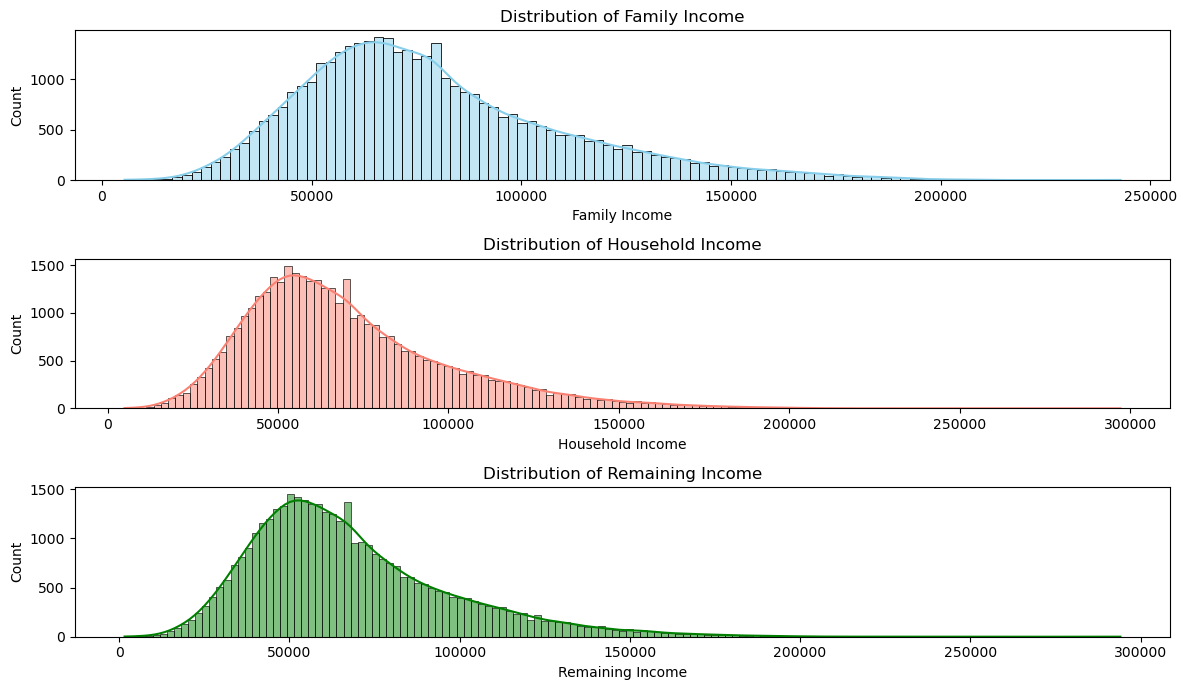

In [79]:
'''   create Remaining Income column. FORMULA: Household Income - (Rent Mean + Monthly Mortgage and Owner Costs Mean)
 NOTE: this dataset only gives us access to housing information, so other basic neccessities are not accounted for in the formula  '''
df['remaining_income'] = df['hi_mean'] - (df['rent_mean'] + df['hc_mortgage_mean'])

plt.figure(figsize=(12, 7))

# Plot the distribution of Family Income, including kde for each plot
plt.subplot(3, 1, 1)
sns.histplot(df['family_mean'], kde=True, color='skyblue')
plt.xlabel('Family Income')
plt.title('Distribution of Family Income')

# Plot the distribution of Household Income
plt.subplot(3, 1, 2)
sns.histplot(df['hi_mean'], kde=True, color='salmon')
plt.xlabel('Household Income')
plt.title('Distribution of Household Income')

# Plot the distribution of Remaining Income
plt.subplot(3, 1, 3)
sns.histplot(df['remaining_income'], kde=True, color='green')
plt.xlabel('Remaining Income')
plt.title('Distribution of Remaining Income')

plt.tight_layout()

Perform EDA and come out with insights into population density and age

In [60]:
# create new columns pop_density and median_age (male and female)
df['population_density'] = df['pop'] / df['ALand']
# weight the new median age column
df['median_age'] = (df['male_age_median'] * df['male_pop'] * df['male_age_sample_weight'] +
                    df['female_age_median'] * df['female_pop'] * df['female_age_sample_weight']) / \
                   (df['male_pop'] * df['male_age_sample_weight'] + df['female_pop'] * df['female_age_sample_weight'])

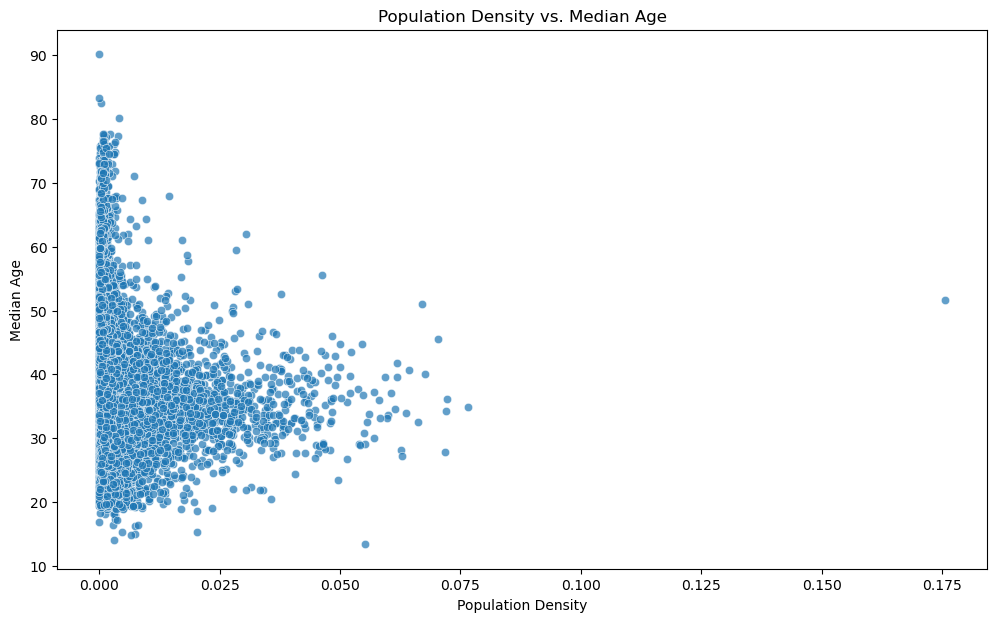

In [61]:
# plot the pop density vs median age via a scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(x='population_density', y='median_age', data=df, alpha=0.7)
plt.title('Population Density vs. Median Age')
plt.xlabel('Population Density')
plt.ylabel('Median Age')
plt.show()

Create 5 interval bins for population 

In [62]:
bin_edges = [0, 1000, 2000, 3000, 4000, float('inf')]

#   define bin labels
bin_labels = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k+']

#   create a new variable 'population_bins'
df['population_bins'] = pd.cut(df['pop'], bins=bin_edges, labels=bin_labels, include_lowest=True)

#   display the DataFrame with the new variable
print(df[['pop', 'population_bins']].head())

    pop population_bins
0  5230             4k+
1  2633           2k-3k
2  6881             4k+
3  2700           2k-3k
4  5637             4k+


Analyze the married, separated, and divorced population for the population brackets

In [63]:
marital_status_summary = df.groupby('population_bins')[['married', 'separated', 'divorced']].sum()
print(marital_status_summary)

                     married   separated     divorced
population_bins                                      
0-1k               250.08479   14.803444    62.003282
1k-2k             1402.32403   71.899120   348.204610
2k-3k             3284.66443  136.475450   736.889470
3k-4k             4235.27192  160.302690   857.506110
4k+              10521.72846  356.517720  1871.171440


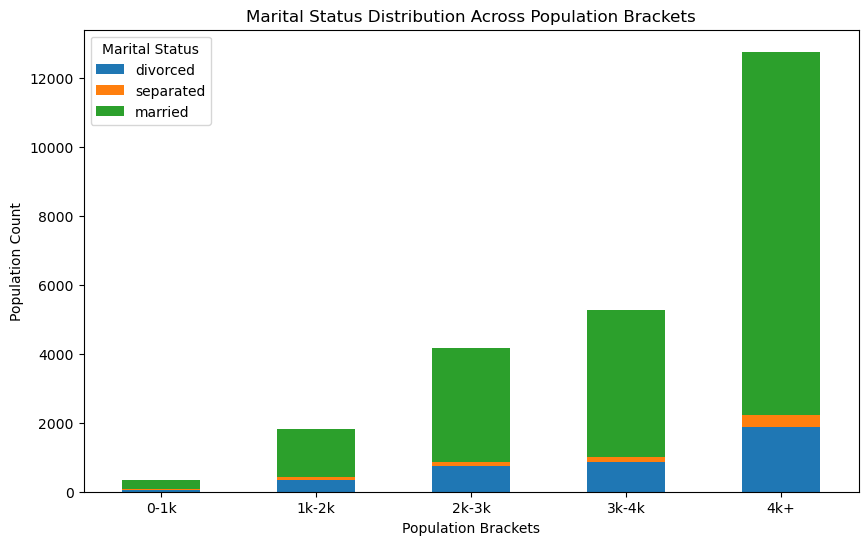

In [64]:
# reverse the order of columns to invert the stacking order (so that the greater value "married" is on top)
marital_status_chart = marital_status_summary[['divorced', 'separated', 'married']]

# plotting with inverted stacking order
ax = marital_status_chart.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Marital Status Distribution Across Population Brackets')
plt.xlabel('Population Brackets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, ha='center') # the space is wide enough to support a flat axis label
plt.ylabel('Population Count')
plt.legend(title='Marital Status', loc='upper left')
plt.show()

Observations for Rent as a percentage of Income at an Overall and State level

In [65]:
#   create rent_percentage column using median (minimize the skewness)
df['rent_percentage'] = (df['rent_median'] / df['hi_median']) * 100

#   OVERALL rent to income percentage
overall_stats = df['rent_percentage'].describe()
state_stats = df['rent_percentage']
print("Overall Observations:")
print(overall_stats)

#   STATE grouped rent to income percentage
state_stats = df.groupby('state')['rent_percentage'].describe()
print("\nState-Level Observations:")
print(state_stats)

Overall Observations:
count    38715.000000
mean         1.944790
std          0.815024
min          0.144874
25%          1.440635
50%          1.794239
75%          2.273535
max         37.181628
Name: rent_percentage, dtype: float64

State-Level Observations:
                       count      mean       std       min       25%  \
state                                                                  
Alabama                612.0  1.876535  0.726146  0.274948  1.420325   
Alaska                 105.0  1.707308  0.518242  0.891836  1.389673   
Arizona                790.0  2.081644  0.789631  0.559795  1.683732   
Arkansas               361.0  1.779026  0.580156  0.562306  1.412693   
California            4150.0  2.295640  0.730147  0.396305  1.830510   
Colorado               663.0  1.841790  0.517834  0.412353  1.507914   
Connecticut            443.0  1.913913  1.850486  0.363165  1.305199   
Delaware               109.0  1.901749  0.683464  0.839452  1.587979   
District of Colum

Perform correlation analysis for all the relevant variables via Heatmap

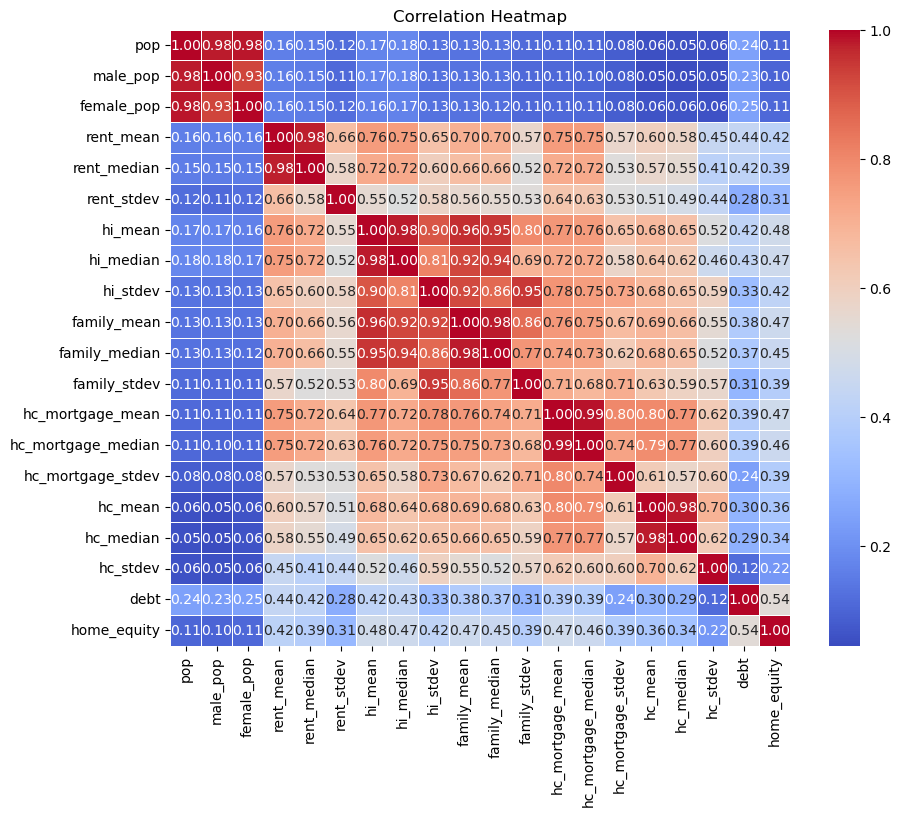

In [66]:
#   create a list that includes relevant, numeric columns only
numeric_columns = [
    'pop', 'male_pop', 'female_pop', 'rent_mean', 'rent_median', 'rent_stdev', 
    'hi_mean', 'hi_median', 'hi_stdev', 'family_mean', 'family_median', 'family_stdev',
    'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev', 'hc_mean', 'hc_median', 'hc_stdev', 'debt', 'home_equity']
numeric_df = df[numeric_columns]
correlation_matrix = numeric_df.corr()

#   create tbe heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [67]:
'''   Quick observations: as expected, Debt has a considerable amount of correlation (0.54) with home_equity, which are two 
very important factors when considering Mortgage Backed Securities. With the next highest correlation for debt being rent_mean.
Household Income and Family Income are highly correlated across the board, no surprise there, but definitely should be accounted for regardless. 
'''

'   Quick observations: as expected, Debt has a considerable amount of correlation (0.54) with home_equity, which are two \nvery important factors when considering Mortgage Backed Securities. With the next highest correlation for debt being rent_mean.\nHousehold Income and Family Income are highly correlated across the board, no surprise there, but definitely should be accounted for regardless. \n'


The economic multivariate data has a significant number of measured variables.
The goal is to find where the measured variables depend on a number of smaller unobserved common factors or latent variables. 
Use factor analysis to find latent variables in the dataset and gain insight into the linear 
relationships in the data.